In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated, List
import operator
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import Send
from IPython.display import display, Image, Markdown
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from pprint import pprint
from langfuse.callback import CallbackHandler

llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0.2)
langfuse_handler = CallbackHandler()

## Create Tools

In [2]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b. "
    Args:
        a: The first number.
        b: The second number."
    """

    return a * b

@tool
def add(a: int, b: int) -> int:
    """Add a and b. "
    Args:
        a: The first number.
        b: The second number."
    """
    return a + b
@tool
def divide(a: int, b: int) -> int:
    """Divide a and b. "
    Args:
        a: The first number.
        b: The second number."
    """

    return a / b

tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

## Create functions

In [3]:
def llm_call(state:MessagesState):
    """LLM decides whether to call a tool or not."""

    return {
        "messages":[
            llm_with_tools.invoke(
                [
                    SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs")
                ]
                + state["messages"]
            )
        ]
    }

def tool_node(state: dict):
    result = []
    for tool_call in state['messages'][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

def shoud_continue(state: MessagesState):
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""
    
    messages = state["messages"]
    last_message = messages[-1]

    if last_message.tool_calls:
        return "Action"
    return END

## Create the Graph

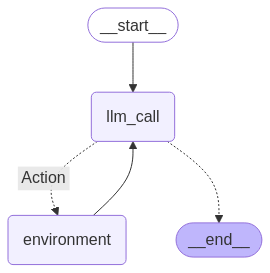

In [4]:
builder = StateGraph(MessagesState)

builder.add_node("environment", tool_node)
builder.add_node("llm_call", llm_call)

builder.add_edge(START, "llm_call")
builder.add_conditional_edges("llm_call", 
                              shoud_continue, 
                              {
                                  "Action": "environment",
                                  END: END
                              },)
builder.add_edge("environment", "llm_call")

agent = builder.compile()

display(Image(agent.get_graph().draw_mermaid_png()))


In [5]:
messages = [HumanMessage(content="Add 3 and 4. Then multiply the result by 8. And finally divide the result by 2.")]
state = agent.invoke({"messages": messages}, config={"callbacks": [langfuse_handler]})
for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Then multiply the result by 8. And finally divide the result by 2.
================================== Ai Message ==================================
Tool Calls:
  add (call_bdMsjWpG0HCSqbcibzog188g)
 Call ID: call_bdMsjWpG0HCSqbcibzog188g
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_CF3GYIGWgvfWM4NqmF0ploVj)
 Call ID: call_CF3GYIGWgvfWM4NqmF0ploVj
  Args:
    a: 7
    b: 8
  divide (call_M5ED3bnwe7N75dgyjK9nU9JH)
 Call ID: call_M5ED3bnwe7N75dgyjK9nU9JH
  Args:
    a: 7
    b: 2
================================= Tool Message =================================

56
================================= Tool Message =================================

3.5
================================== Ai Message ===============================

## We can use prebuilt Agent

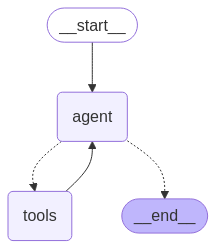

In [5]:
from langgraph.prebuilt import create_react_agent
pre_build_agent = create_react_agent(llm_with_tools, tools = tools)
display(Image(pre_build_agent.get_graph().draw_mermaid_png()))


In [25]:
messages = [HumanMessage(content="Add 500 and 4")]
state = pre_build_agent.invoke({"messages": messages}, config={"callbacks": [langfuse_handler]})

for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 500 and 4
================================== Ai Message ==================================
Tool Calls:
  add (call_gf5lsw5z2nlEUQu0vQGHTOmr)
 Call ID: call_gf5lsw5z2nlEUQu0vQGHTOmr
  Args:
    a: 500
    b: 4
================================= Tool Message =================================
Name: add

504
================================== Ai Message ==================================

The sum of 500 and 4 is 504.


In [26]:
messages = [HumanMessage(content="Add 500 and 4 and then divide the result by 2")]
state = pre_build_agent.invoke({"messages": messages}, config={"callbacks": [langfuse_handler]})

for m in state["messages"]:
    m.pretty_print()

================================ Human Message =================================

Add 500 and 4 and then divide the result by 2
================================== Ai Message ==================================
Tool Calls:
  add (call_HIlxJJErgkZElEilk6eMzvDA)
 Call ID: call_HIlxJJErgkZElEilk6eMzvDA
  Args:
    a: 500
    b: 4
================================= Tool Message =================================
Name: add

504
================================== Ai Message ==================================
Tool Calls:
  divide (call_97DT50Imrkc15mPEADCBVMlK)
 Call ID: call_97DT50Imrkc15mPEADCBVMlK
  Args:
    a: 504
    b: 2
================================= Tool Message =================================
Name: divide

252.0
================================== Ai Message ==================================

The result of adding 500 and 4 is 504, and dividing that by 2 gives 252.0.
